In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.expanduser("~"), "datacube_jupyter_notebooks/"))
import helpers.helpers as helpers

from DQTools.dataset import Dataset
from helpers.smoothn import smoothn
from helpers.helpers import Helpers

import xarray as xr
import numpy as np
import math

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import pandas as pd
import ipywidgets as widgets
from ipywidgets import HBox

from IPython.display import clear_output
from IPython.display import display
from IPython.lib.display import FileLink

In [2]:
farms = pd.read_csv('../data/WeatherStationsFarms.csv', header=1)

farms_subset = farms[['STATION_ID','FARMER NAME']]
farms_subset_list = farms_subset.values.tolist()

In [3]:
product = 'era5_land'
subproduct = 'rh'
h = Helpers(out=None)

fig, (ax, bx) = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches(9.0, 7.0)

def get_station_data(station):
    """
    Get data for a particular station
    """
    fname = f'{station}_averages.csv'
    fname = os.path.join('../data', fname)
    
    try:
        data = pd.read_csv(fname)
    except FileNotFoundError as e:
        print(e)
        return None
    
    # Convert GMT date to datetime
    # removed conversion to np.datetime64 as it is a series 
    # so should already be in np.datetime64 after use of .to_datetime
    data.date = pd.to_datetime(data.date, format='%d/%m/%Y %H:%M')
    
    return data


def on_get_data_click(b):

    # Join data
    df = _merged.to_dataframe(name='adjusted_rh')
    series = _merged_unc.to_dataframe(name='adjusted_rh_unc')['adjusted_rh_unc']

    tmp_df = df.join(series, on='time')
    
    fname = f'{str(dropdown_farms.value)}_merged_rh.csv'
    
    tmp_df.to_csv(fname)
    localfile = FileLink(fname)
        
    display(localfile)
    

def calculate_humidity(lat, lon, start, stop):
    # removed usage of local method to method from helpers to remove repeated code
    t2m = h.get_data_from_datacube(product, 't2m', start, stop, lat, lon)
    d2m = h.get_data_from_datacube(product, 'd2m', start, stop, lat, lon)

    t2m_val = t2m.t2m.values - 273.15
    d2m_val = d2m.d2m.values - 273.15
    
    output = xr.full_like(d2m, 1)
    
    equation = lambda t, d: 100 * (math.exp((17.625*d)/(243.04+d))/math.exp((17.625*t)/(243.04+t)))
    vfunc = np.vectorize(equation)
    output.d2m.values = vfunc(t2m_val, d2m_val)
    
    output = output.rename({'d2m': subproduct})
    
    return output


def on_dropdown_farms_change(change):
    """
    Handles change event on dropdown_farms widget
    """
    if change['type'] == 'change' and change['name'] == 'value':
        ax.clear()
        bx.clear()
        
        farm_data = farms[farms.STATION_ID==dropdown_farms.value]
        
        data = get_station_data(dropdown_farms.value)
        if data is None:
            return None

        # Extract Station location 
        locations = pd.read_csv(os.path.join("../data", "_locations.csv"))
        lat = locations[locations['sid'] == dropdown_farms.value]['lat'].iloc[0]
        lon = locations[locations['sid'] == dropdown_farms.value]['lon'].iloc[0]
   
        # Plot original data
        ax.plot(data['date'], data['Relative.Humidity_hourly.mean'],
                label='Relative.Humidity_hourly.mean', marker='+', lw=0.5, color='C0')
        
        # Plot ERA5 skt data
        # removed convsersion to string so that it only uses datetimes now
        start = data['date'].iloc[0].to_pydatetime()
        end = data['date'].iloc[-1].to_pydatetime()
        
        rh = calculate_humidity(lat, lon, start.date(), end.date())
        
        # Kelvin to Celcius
        getattr(rh, subproduct).plot(ax=ax, label=f'{product} - {subproduct}',
                               lw=0.5, color='C1')
        
        ax.grid()
        ax.set_title(farm_data['FARMER NAME'].values[0])
        ax.legend(loc='best', fontsize='small',
                  fancybox=True, framealpha=0.5)
        
        # Transform station data to data array
        _data = xr.DataArray(data['Relative.Humidity_hourly.mean'],
                             name='Relative.Humidity_hourly.mean.QC',
                             dims=['time'],
                             coords={'latitude' : rh.latitude.values,
                                     'longitude' : rh.longitude.values,
                                     'time' : data['date']})
        
        # Create merged dataset
        global merged
        merged = xr.merge([_data, getattr(rh, subproduct)])
        
        getattr(merged, subproduct).plot(ax=bx, label=f'{product} - {subproduct} (adjusted)',
                                         color='C1')
        
        getattr(merged, 'Relative.Humidity_hourly.mean.QC').plot(ax=bx,
                label=f'Relative.Humidity_hourly.mean.QC', color='C0')
        
        bx.fill_between(getattr(merged, subproduct).time.data,
                        getattr(merged, subproduct).data,
                        getattr(merged, 'Relative.Humidity_hourly.mean.QC').data,
                        alpha=0.2)
        
        global _merged
        _merged = (getattr(merged, 'Relative.Humidity_hourly.mean.QC') + 
                   merged.rh) / 2.0
        # Fill NaNs where there is NO in-situ obs
        idx = np.argwhere(np.isnan(_merged.data))
        _merged.data[idx] = merged.rh.data[idx]
        
        # Uncertainty
        global _merged_unc
        _merged_unc = (getattr(merged, 'Relative.Humidity_hourly.mean.QC') - 
                       merged.rh)
        _merged_unc.data = np.absolute(_merged_unc.data)
        # Nominal uncert
        _merged_unc.data[idx] = merged.rh.data[idx] * 0.1
        
        # Fill NaNs where there is NO ERA5 data
        idx = np.argwhere(np.isnan(merged.rh.data))
        times = merged.rh.time.data[idx]

        # These values are np.datetime64 then turned into string which 
        # comes out in a standard format, don't like it but don't see an easy way to change this
        start = times[0][0].astype(str)
        end = times[-1][0].astype(str)

        _merged.data[idx[:,0]] = \
        getattr(merged, 'Relative.Humidity_hourly.mean.QC').sel(time=slice(start[0:-10], end[0:-10]))

        _merged_unc.data[idx[:,0]] = _merged.data[idx[:,0]] * 0.1
        
        upper_uncertainty = _merged.data + _merged_unc.data
        upper_uncertainty[upper_uncertainty > 100] = 100
        
        # Plot merged dataset
        _merged.plot(ax=bx, color='C2', label='Merged humidity dataset')
        bx.fill_between(_merged.time.data,
                        upper_uncertainty,
                        _merged.data - _merged_unc.data,
                        alpha=0.2, color='C2')
        
        bx.grid()
        bx.legend(loc='best', fontsize='small',
                  fancybox=True, framealpha=0.5)
        
        get_data.disabled = False
        
        plt.show()

In [4]:
# Dropdown widget with all farms
dropdown_farms = widgets.Dropdown(
    options=farms['STATION_ID'],
    value=farms['STATION_ID'][0],
    description='Farm:',
    disabled=False,
)

dropdown_farms.observe(on_dropdown_farms_change)

get_data = widgets.Button(
    description='Get merged dataset',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    icon='file' # (FontAwesome names without the `fa-` prefix)
)

get_data.on_click(on_get_data_click)

## Farm analytics

Select a farm ID to explore the datasets. Click on 'Get merged data' to get an text file of the merged dataset.

<IPython.core.display.Javascript object>


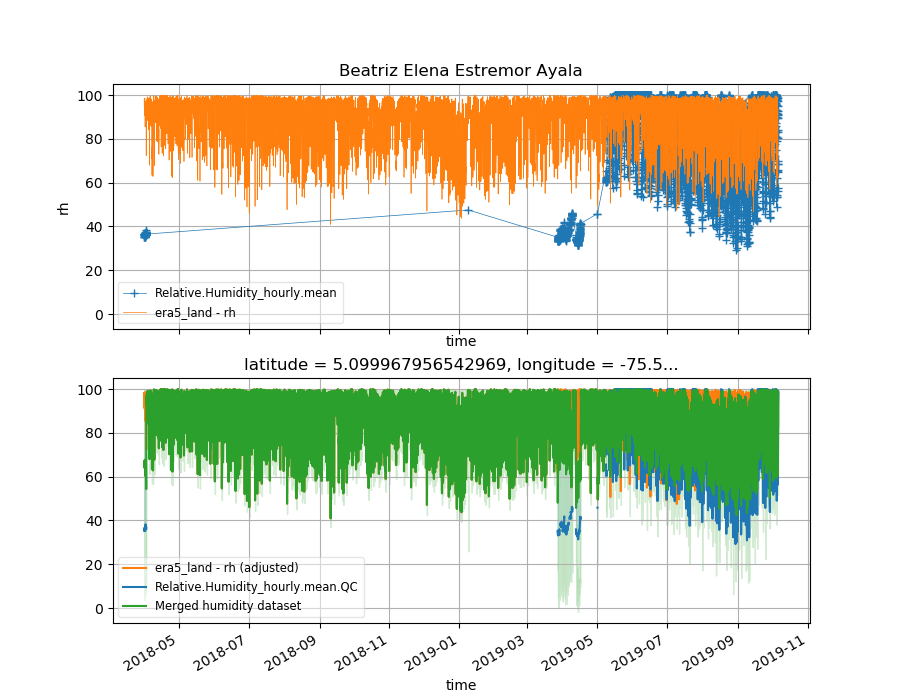

/home/jupyter-assimila/datacube_jupyter_notebooks/IUKColombia/997134129_merged_rh.csv

In [5]:
HBox([dropdown_farms, get_data])
#display(dropdown_farms)
#display(get_data)